<a href="https://colab.research.google.com/github/rpaiva2104/git_github_Paiva/blob/main/Projeto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relatório de Análise e Modelagem Preditiva: Satisfação do Cliente na Olist


Visão Geral do Dataset:

Nome do Dataset: Brazilian E-Commerce Public Dataset by Olist

Origem dos Dados :https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

Número de Linhas: 117329

Número de Colunas: 39

Equipe:

    Carlos André Pereira de Lucena

    Elayne Lima Santos

    Erinaldo Santos

    Patrícia de Souza Leão Silva

    Reginaldo Paiva de O. Junior

    Rodrigo Luiz de Souza Couto

# **1. O Início: Entendimento do Negócio**


 Objetivo do Projeto: Compreender os fatores que levam à insatisfação dos clientes e prever se um cliente dará uma avaliação negativa.
 Os dados se originam de 9 arquivos .csv, a combinação dessas tabelas cria um panorama completo do ciclo de vendas da Olist. Podemos rastrear um pedido do início ao fim, desde a sua criação, passando pelo pagamento e entrega, até a avaliação final do cliente. Isso nos permite identificar gargalos, otimizar processos e, em última análise, melhorar a experiência do cliente, o que é o objetivo principal


#**2. Entendimento e preparação dos dados**


**Utilizamos o "Brazilian E-Commerce Public Dataset by Olist", um conjunto de dados anônimos e do mundo real, contendo mais de 100.000 pedidos. Os dados são relacionais e estão distribuídos em múltiplos arquivos CSV, que representam diferentes entidades do negócio, como:**
    
*   Pedidos (orders): Informações centrais sobre cada pedido, incluindo IDs, status e timestamps.
*   Clientes (customers): Dados demográficos dos clientes, como cidade e estado.
*   Avaliações (reviews): As notas (de 1 a 5) e comentários deixados pelos clientes. Esta fonte contém nossa variável-alvo.
*   Itens do Pedido (order_items): Detalhes sobre os produtos contidos em cada pedido.
*   Pagamentos (payments): Informações sobre a forma e o valor do pagamento.
*   Produtos (products): Detalhes sobre os produtos, como categoria e dimensões.

Antes de começar, precisamos unir as tabelas para ter uma visão completa. O foco é a review_score, então a tabela olist_order_reviews_dataset.csv será a nossa base. A partir dela, vamos juntar as outras tabelas usando as chaves em comum, como order_id, customer_id, e seller_id

Para começar precisamos unir todas as peças do quebra-cabeça, ou seja, as tabelas que contém os dados. Para entender o que motiva uma nota de review_score alta ou baixa, precisamos de um conjunto de dados único que conecte o cliente, o produto, o vendedor e o histórico do pedido. Esta etapa de junção é a fundação da nossa análise, garantindo que podemos rastrear cada avaliação até suas origens.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

# Coletando os Dados e Juntando os Datasets (Merge)

In [ ]:
# Carregar os datasets
orders = pd.read_csv('olist_orders_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')

# Unir os dataframes
df_analise = reviews.merge(orders, on='order_id')
df_analise = df_analise.merge(payments, on='order_id')
df_analise = df_analise.merge(order_items, on='order_id')
df_analise = df_analise.merge(products, on='product_id')
df_analise = df_analise.merge(sellers, on='seller_id')
df_analise = df_analise.merge(customers, on='customer_id')

print(df_analise.head())



                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
2  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
3  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
4  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   

   review_score review_comment_title                 review_comment_message  \
0             4                  NaN                                    NaN   
1             4                  NaN                                    NaN   
2             5                  NaN                                    NaN   
3             5                  NaN                                    NaN   
4             5                  NaN  Recebi bem antes do prazo estipulado.   

  review_creation_date review_answer_timestamp  \
0  2018-01-18 00:00:00     2018-01-1

#**3. Análise Exploratória de Dados (AED)**

Com o dataset preparado, a próxima etapa é explorar a distribuição da nossa variável-alvo. O objetivo é entender a proporção de notas 1, 2, 3, 4 e 5. Isso nos dará uma noção inicial do sentimento geral dos clientes.
Temos que trabalha na coluna review_score e responder as seguintes perguntas: Qual é a nota mais comum? O que a distribuição de notas nos diz sobre a satisfação dos clientes da Olist? Um gráfico de barras simples nos revela a verdade por trás das avaliações. Porém, antes, precisamos realizar um pré-processamento dos dados e uma análise descritiva dos dados.

## Pré-processamento

In [ ]:
df_analise.shape

(117329, 39)

In [ ]:
df_analise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   review_id                      117329 non-null  object 
 1   order_id                       117329 non-null  object 
 2   review_score                   117329 non-null  int64  
 3   review_comment_title           13892 non-null   object 
 4   review_comment_message         49679 non-null   object 
 5   review_creation_date           117329 non-null  object 
 6   review_answer_timestamp        117329 non-null  object 
 7   customer_id                    117329 non-null  object 
 8   order_status                   117329 non-null  object 
 9   order_purchase_timestamp       117329 non-null  object 
 10  order_approved_at              117314 non-null  object 
 11  order_delivered_carrier_date   116094 non-null  object 
 12  order_delivered_customer_date 

In [ ]:
df_analise.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,1,credit_card,8,397.26,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,14600,sao joaquim da barra,SP,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,1,credit_card,8,397.26,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,14600,sao joaquim da barra,SP,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00,1,credit_card,1,88.09,1,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30,informatica_acessorios,47.0,493.0,1.0,245.0,19.0,14.0,14.0,12233,sao jose dos campos,SP,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00,1,credit_card,1,194.12,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-02-08 10:31:15,149.00,45.12,informatica_acessorios,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,37175,ilicinea,MG,1d47144362c14e94ccdd213e8ec277d5,44571,santo antonio de jesus,BA
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,1,credit_card,1,222.84,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85,ferramentas_jardim,33.0,2188.0,2.0,7650.0,20.0,20.0,20.0,37175,ilicinea,MG,c8cf6cb6b838dc7a33ed199b825e8616,88735,gravatal,SC


In [ ]:
df_analise.isna().sum()

review_id                             0
order_id                              0
review_score                          0
review_comment_title             103437
review_comment_message            67650
review_creation_date                  0
review_answer_timestamp               0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    15
order_delivered_carrier_date       1235
order_delivered_customer_date      2471
order_estimated_delivery_date         0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name              1695


## Análise Descritiva

In [ ]:
#Analisando valores quantitativos
df_analise.describe()

,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,customer_zip_code_prefix
count,117329.000000,117329.000000,117329.000000,117329.000000,117329.000000,117329.000000,117329.000000,115634.000000,115634.000000,115634.000000,117309.000000,117309.000000,117309.000000,117309.000000,117329.000000,117329.000000
mean,4.031467,1.094452,2.940151,172.062565,1.194121,120.524349,20.027514,48.768018,785.802861,2.205528,2110.763062,30.254456,16.612476,23.071452,24450.781955,35060.118112
std,1.387927,0.731174,2.775370,265.388194,0.684225,182.944843,15.828077,10.033831,652.382965,1.717783,3785.128931,16.177519,13.452625,11.745875,27582.364358,29849.496175
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,1003.000000
25%,4.000000,1.000000,1.000000,60.750000,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,11250.000000
50%,5.000000,1.000000,2.000000,108.100000,1.000000,74.900000,16.280000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,24240.000000
75%,5.000000,1.000000,4.000000,189.060000,1.000000,134.900000,21.180000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28035.000000,58770.000000
max,5.000000,29.000000,24.000000,13664.080000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,99990.000000


In [ ]:
#Analisando valores qualitativos
df_analise.describe(include='all')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,117329,117329,117329.000000,13892,49679,117329,117329,117329,117329,117329,117314,116094,114858,117329,117329.000000,117329,117329.000000,117329.000000,117329.000000,117329,117329,117329,117329.000000,117329.000000,115634,115634.000000,115634.000000,115634.000000,117309.000000,117309.000000,117309.000000,117309.000000,117329.000000,117329,117329,117329,117329.000000,117329,117329
unique,97708,97916,NaN,4497,35691,632,97546,97916,7,97370,89533,80449,95021,449,NaN,4,NaN,NaN,NaN,32789,3090,92642,NaN,NaN,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,611,23,94720,NaN,4108,27
top,eef5dbca8d37dfce6db7d7b16dd0525e,895ab968e7bb0d5659d16cd74cd1650c,NaN,Recomendo,Muito bom,2017-12-19 00:00:00,2017-08-17 22:17:55,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,NaN,credit_card,NaN,NaN,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,NaN,NaN,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sao paulo,SP,9a736b248f67d166d2fbb006bcb877c3,NaN,sao paulo,SP
freq,63,63,NaN,494,259,542,63,63,114859,63,63,63,63,652,NaN,86520,NaN,NaN,NaN,533,2128,63,NaN,NaN,11847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29048,83671,75,NaN,18582,49527
mean,NaN,NaN,4.031467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.094452,NaN,2.940151,172.062565,1.194121,NaN,NaN,NaN,120.524349,20.027514,NaN,48.768018,785.802861,2.205528,2110.763062,30.254456,16.612476,23.071452,24450.781955,NaN,NaN,NaN,35060.118112,NaN,NaN
std,NaN,NaN,1.387927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.731174,NaN,2.775370,265.388194,0.684225,NaN,NaN,NaN,182.944843,15.828077,NaN,10.033831,652.382965,1.717783,3785.128931,16.177519,13.452625,11.745875,27582.364358,NaN,NaN,NaN,29849.496175,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,0.000000,1.000000,NaN,NaN,NaN,0.850000,0.000000,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,NaN,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,60.750000,1.000000,NaN,NaN,NaN,39.900000,13.080000,NaN,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,NaN,NaN,NaN,11250.000000,NaN,NaN
50%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,2.000000,108.100000,1.000000,NaN,NaN,NaN,74.900000,16.280000,NaN,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,NaN,NaN,NaN,24240.000000,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,4.000000,189.060000,1.000000,NaN,NaN,NaN,134.900000,21.180000,NaN,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28035.000000,NaN,NaN,NaN,58770.000000,NaN,NaN


In [ ]:
#Analisando correlações
df_numerico = df_analise.select_dtypes(include=['number'])
correlacoes = df_numerico.corr()
correlacoes

,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,customer_zip_code_prefix
review_score,1.000000,-0.004634,-0.042279,-0.082404,-0.129344,-0.004515,-0.037076,-0.006323,0.010354,0.022266,-0.028641,-0.020441,-0.026409,-0.010743,0.026143,-0.023349
payment_sequential,-0.004634,1.000000,-0.086130,-0.064475,-0.002406,0.006717,0.021956,-0.005528,0.009945,-0.010705,0.044021,0.049023,0.024671,0.030868,0.014239,-0.022101
payment_installments,-0.042279,-0.086130,1.000000,0.274334,0.074026,0.279000,0.185774,0.020717,0.036342,-0.000699,0.177936,0.117074,0.122614,0.138328,0.039897,0.056288
payment_value,-0.082404,-0.064475,0.274334,1.000000,0.255814,0.741433,0.374270,0.003298,0.156257,0.009833,0.305458,0.139966,0.216773,0.148374,0.071082,0.053161
order_item_id,-0.129344,-0.002406,0.074026,0.255814,1.000000,-0.061018,-0.030336,-0.023230,-0.016512,-0.054721,-0.003330,0.007149,0.027779,-0.010115,-0.017370,-0.003627
price,-0.004515,0.006717,0.279000,0.741433,-0.061018,1.000000,0.414014,0.017853,0.201950,0.052378,0.340712,0.145386,0.225115,0.172667,0.088714,0.043273
freight_value,-0.037076,0.021956,0.185774,0.374270,-0.030336,0.414014,1.000000,0.022442,0.096853,0.021786,0.611302,0.309137,0.394332,0.324993,0.152097,0.225676
product_name_lenght,-0.006323,-0.005528,0.020717,0.003298,-0.023230,0.017853,0.022442,1.000000,0.089872,0.145183,0.021031,0.058800,-0.030353,0.062877,-0.033087,0.016044
product_description_lenght,0.010354,0.009945,0.036342,0.156257,-0.016512,0.201950,0.096853,0.089872,1.000000,0.117374,0.064236,0.007836,0.073896,-0.068087,0.062471,0.025582
product_photos_qty,0.022266,-0.010705,-0.000699,0.009833,-0.054721,0.052378,0.021786,0.145183,0.117374,1.000000,0.021121,0.044444,-0.034560,0.006269,-0.042084,0.020668


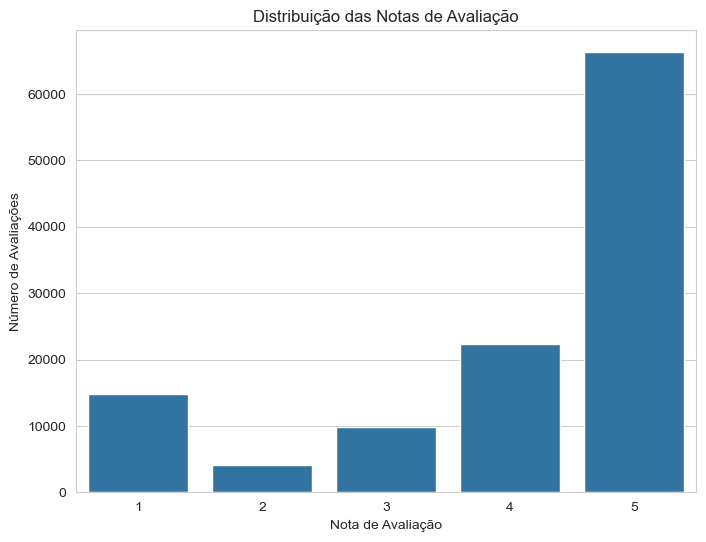

review_score
1    14854
2     4085
3     9840
4    22286
5    66264
Name: count, dtype: int64


In [ ]:
# Contar a frequência de cada nota
review_counts = df_analise['review_score'].value_counts().sort_index()
# Plotar o gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=review_counts.index, y=review_counts.values)
plt.title('Distribuição das Notas de Avaliação')
plt.xlabel('Nota de Avaliação')
plt.ylabel('Número de Avaliações')
plt.show()
print(review_counts)

O gráfico mostra uma concentração significativa de notas 4 e 5, o que é um sinal positivo para o negócio. No entanto, as notas 1 e 2 também são relevantes, indicando que há espaço para melhoria. O nosso desafio agora é descobrir o que diferencia uma nota alta de uma baixa

#**4. Engenharia de Atributos e Análise de Correlação**

Para ir além, vamos criar novas variáveis que possam explicar a review_score. O tempo de entrega, por exemplo, é um fator crucial. Vamos calcular a diferença entre a data de entrega e a data de envio. Além disso, podemos analisar a correlação entre a nota e outras variáveis numéricas, como o valor do pagamento.
As variáveis que temos são importantes, mas podemos torná-las ainda mais poderosas. Ao calcular o tempo de entrega e o atraso na entrega, criamos indicadores que têm um impacto direto na satisfação do cliente. A seguir, vamos investigar se existe uma relação entre essas novas variáveis e a nota do review.


In [ ]:
df_analise['satisfaction'] = (df_analise['review_score'] >= 4).astype(int)

1. df['review_score'] >= 4
Comparação: Esta parte verifica se a pontuação da avaliação é igual ou maior que 4

Resultado: Retorna uma série de valores booleanos (True/False)

Exemplo:

Se review_score = 5 → True

Se review_score = 3 → False

Se review_score = 4 → True

2. .astype(int)
Conversão: Transforma os valores booleanos em números inteiros

Mapeamento:

True → 1 (satisfeito)

False → 0 (insatisfeito)

3. df['satisfaction'] = ...
Atribuição: Cria uma nova coluna chamada 'satisfaction' no DataFrame

Armazenamento: Guarda os valores 0 ou 1 resultantes da operação

A Lógica por Trás da Escolha
Por que ≥ 4?
Esta escolha comum em análise de satisfação considera:

⭐⭐⭐⭐ (4) e ⭐⭐⭐⭐⭐ (5): Clientes satisfeitos

⭐ (1), ⭐⭐ (2), ⭐⭐⭐ (3): Clientes insatisfeitos

Vantagens desta abordagem:
Simplificação: Transforma uma escala de 5 pontos em uma métrica binária clara

Análise mais fácil: Facilita modelos de classificação e análise estatística

Interpretação intuitiva: 1 = satisfeito, 0 = insatisfeito

In [ ]:

# # Converter colunas de datas para datetime
df_analise['order_purchase_timestamp'] = pd.to_datetime(df_analise['order_purchase_timestamp'])

# Usa .assign() para criar todas as novas colunas de uma vez
df_analise = df_analise.assign(
    purchase_hour = df_analise['order_purchase_timestamp'].dt.hour,
    purchase_day = df_analise['order_purchase_timestamp'].dt.day,
    purchase_month = df_analise['order_purchase_timestamp'].dt.month,
    purchase_dayofweek = df_analise['order_purchase_timestamp'].dt.day_name() # .day_name() é uma alternativa que retorna o nome do dia (ex: 'Monday')
)

Visualização do DataFrame agregado:
                           order_id  payment_value   price  product_weight_g  \
0  00010242fe8c5a6d1ba2dd792cb16214          72.19   58.90             650.0   
1  00018f77f2f0320c557190d7a144bdd3         259.83  239.90           30000.0   
2  000229ec398224ef6ca0657da4fc703e         216.87  199.00            3050.0   
3  00024acbcdf0a6daa1e931b038114c75          25.78   12.99             200.0   
4  00042b26cf59d7ce69dfabb4e55b4fd9         218.04  199.90            3750.0   

   freight_value  product_photos_qty  delivery_time  delivery_delay  \
0          13.29                 4.0            7.0            -9.0   
1          19.93                 2.0           16.0            -3.0   
2          17.87                 2.0            7.0           -14.0   
3          12.79                 1.0            6.0            -6.0   
4          18.14                 1.0           25.0           -16.0   

   purchase_hour  purchase_day  purchase_month purchase_

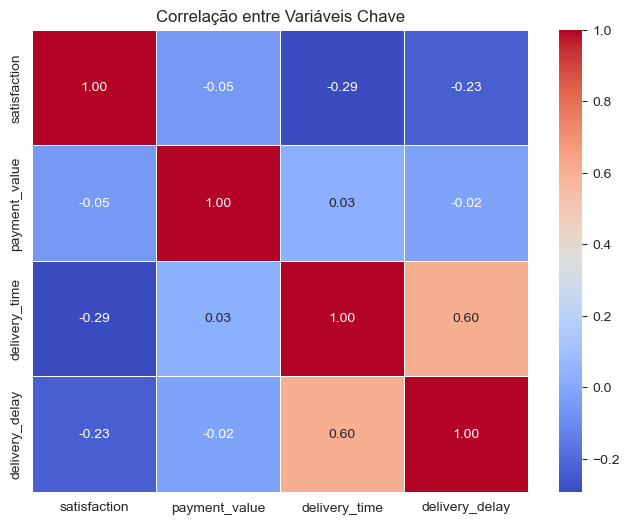

In [ ]:
df_analise['order_purchase_timestamp'] = pd.to_datetime(df_analise['order_purchase_timestamp'])
df_analise['order_delivered_customer_date'] = pd.to_datetime(df_analise['order_delivered_customer_date'])
df_analise['order_estimated_delivery_date'] = pd.to_datetime(df_analise['order_estimated_delivery_date'])

# Calcular tempo de entrega e atraso

df_analise['delivery_time'] = (df_analise['order_delivered_customer_date'] - df_analise['order_purchase_timestamp']).dt.days
df_analise['delivery_delay'] = (df_analise['order_delivered_customer_date'] - df_analise['order_estimated_delivery_date']).dt.days

# --- AGREGAÇÃO POR PEDIDO ---

# Agrupando os dados por 'order_id'
df_final = df_analise.groupby('order_id').agg(
    # Para valores monetários e físicos do pedido, a soma faz sentido
    payment_value=('payment_value', 'sum'),
    price=('price', 'sum'),
    product_weight_g=('product_weight_g', 'sum'),

    # Usando 'first' para o frete, pois ele é único por pedido
    freight_value=('freight_value', 'first'),

    # Para características dos produtos, a média pode ser interessante
    product_photos_qty=('product_photos_qty', 'mean'),

    # Para dados do pedido (que são constantes por pedido), 'first' é eficiente
    delivery_time=('delivery_time', 'first'),
    delivery_delay=('delivery_delay', 'first'),
    purchase_hour=('purchase_hour', 'first'),
    purchase_day=('purchase_day', 'first'),
    purchase_month=('purchase_month', 'first'),
    purchase_dayofweek=('purchase_dayofweek', 'first'),
    satisfaction=('satisfaction', 'first')
).reset_index()

# Agora, o DataFrame `df_final` contém os dados preparados e agregados.
print("Visualização do DataFrame agregado:")
print(df_final.head())

# --- ANÁLISE DE CORRELAÇÃO ---

# Preparar dados para o heatmap (removendo nulos)
# É uma boa prática remover linhas com valores nulos antes de calcular a correlação.
df_corr = df_final[['satisfaction', 'payment_value', 'delivery_time', 'delivery_delay']].dropna()

# Visualizar a correlação com um heatmap
print("\nMatriz de Correlação:")
correlations = df_corr.corr()
print(correlations)

plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlação entre Variáveis Chave')
plt.show()

O Nosso objetivo é descobrir quem são os maiores aliados da satisfação do nosso cliente e seus piores inimigos. Analisamos quatro personagens principais: o Valor da Compra, o Tempo de Entrega, o Atraso na Entrega e, claro, a própria Satisfação.
O heatmap de correlação nos mostra que a variável *satisfaction* tem uma correlação negativa com o tempo de entrega e atraso na entrega. Em outras palavras, quanto maior o tempo de entrega, menor a nota do cliente. Esta é uma evidência de que a logística é um fator crítico para a satisfação do cliente na Olist. Aqui temos a reviravolta da nossa história. Intuitivamente, poderíamos pensar que clientes que gastam mais são mais exigentes e, portanto, sua satisfação poderia variar. Os dados mostram o contrário

A análise revela que a pontualidade na entrega é o fator mais crítico para a satisfação do cliente. Enquanto o tempo total de entrega também é importante, são os atrasos em relação ao prometido que mais impactam negativamente a experiência do cliente. As estratégias de melhoria devem focar tanto na redução dos prazos totais quanto, especialmente, no cumprimento das promessas de entrega feitas aos clientes.

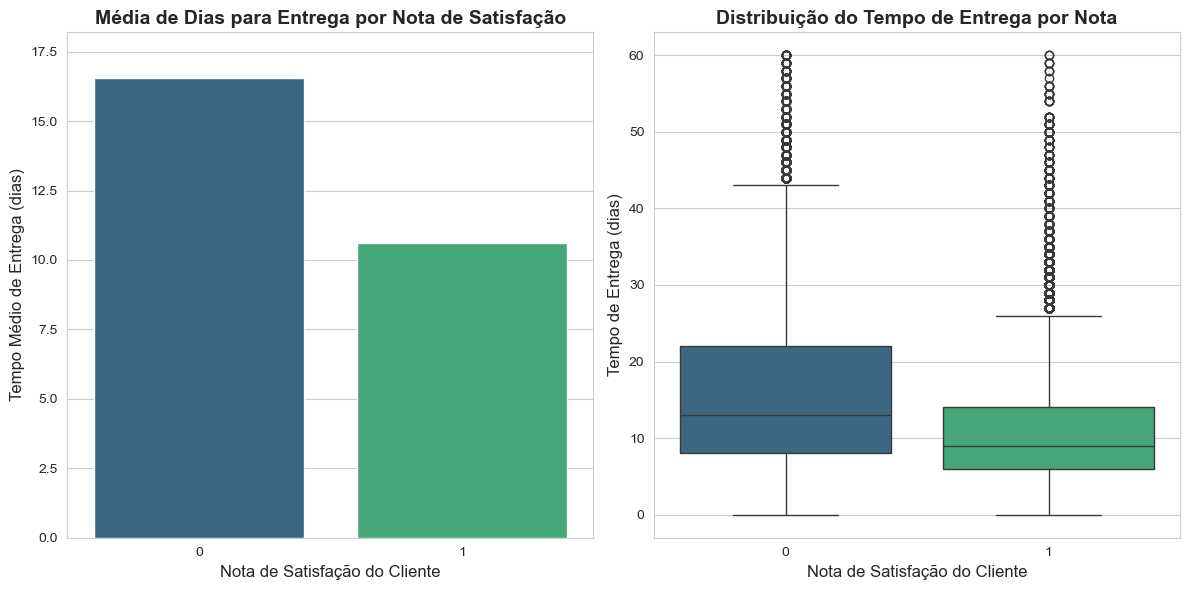

In [ ]:
df_analise['tempo_entrega_dias'] = (df_analise['order_delivered_customer_date'] - df_analise['order_purchase_timestamp']).dt.days

# Gráfico 1: Média do tempo de entrega por nota de satisfação
plt.subplot(1, 2, 1) # Cria uma figura com 1 linha, 2 colunas, e seleciona o 1º gráfico
media_por_nota = df_analise.groupby('satisfaction')['tempo_entrega_dias'].mean().reset_index()
sns.barplot(x='satisfaction', y='tempo_entrega_dias', data=media_por_nota, palette='viridis', hue='satisfaction', dodge=False, legend=False)
plt.title('Média de Dias para Entrega por Nota de Satisfação', fontsize=14, weight='bold')
plt.xlabel('Nota de Satisfação do Cliente', fontsize=12)
plt.ylabel('Tempo Médio de Entrega (dias)', fontsize=12)
plt.ylim(0, media_por_nota['tempo_entrega_dias'].max() * 1.1) # Ajusta o limite do eixo Y

# Gráfico 2: Distribuição do tempo de entrega por nota (Boxplot)
plt.subplot(1, 2, 2) # Seleciona o 2º gráfico
# Para melhor visualização do boxplot, vamos remover outliers extremos (entregas > 60 dias)
sns.boxplot(x='satisfaction', y='tempo_entrega_dias', data=df_analise[df_analise['tempo_entrega_dias'] <= 60], palette='viridis', hue='satisfaction', legend=False)
plt.title('Distribuição do Tempo de Entrega por Nota', fontsize=14, weight='bold')
plt.xlabel('Nota de Satisfação do Cliente', fontsize=12)
plt.ylabel('Tempo de Entrega (dias)', fontsize=12)

# Ajusta o layout e exibe os gráficos
plt.tight_layout()
plt.show()

A história que os dados contam é inequívoca: a logística não é apenas um custo operacional, é um pilar central da experiência do cliente. Atrasos e longos períodos de espera são os principais vilões da satisfação. Para a Olist (e qualquer e-commerce), otimizar o tempo de entrega não é apenas uma melhoria de eficiência, é a estratégia mais direta para aumentar a satisfação, a lealdade e, consequentemente, a reputação da marca.


--- Análise dos Resultados ---

Tempo Médio de Entrega e N. de Pedidos por Estado:
   customer_state       mean  count
21             RR  27.826087     46
3              AP  27.621951     82
2              AM  26.005917    169
1              AL  24.054299    442
13             PA  23.019517   1076
9              MA  21.050184    817
24             SE  20.744792    384
5              CE  20.285237   1497
0              AC  20.170213     94
14             PB  19.872964    614
20             RO  19.235714    280
19             RN  19.153846    559
16             PI  18.908759    548
4              BA  18.668710   3915
15             PE  17.700000   1820
12             MT  17.436975   1071
26             TO  16.678679    333
7              ES  15.090512   2287
11             MS  15.063830    846
8              GO  14.902119   2360
18             RJ  14.712624  14789
22             RS  14.683825   6411
23             SC  14.407848   4205
6              DF  12.495266   2429
17             P

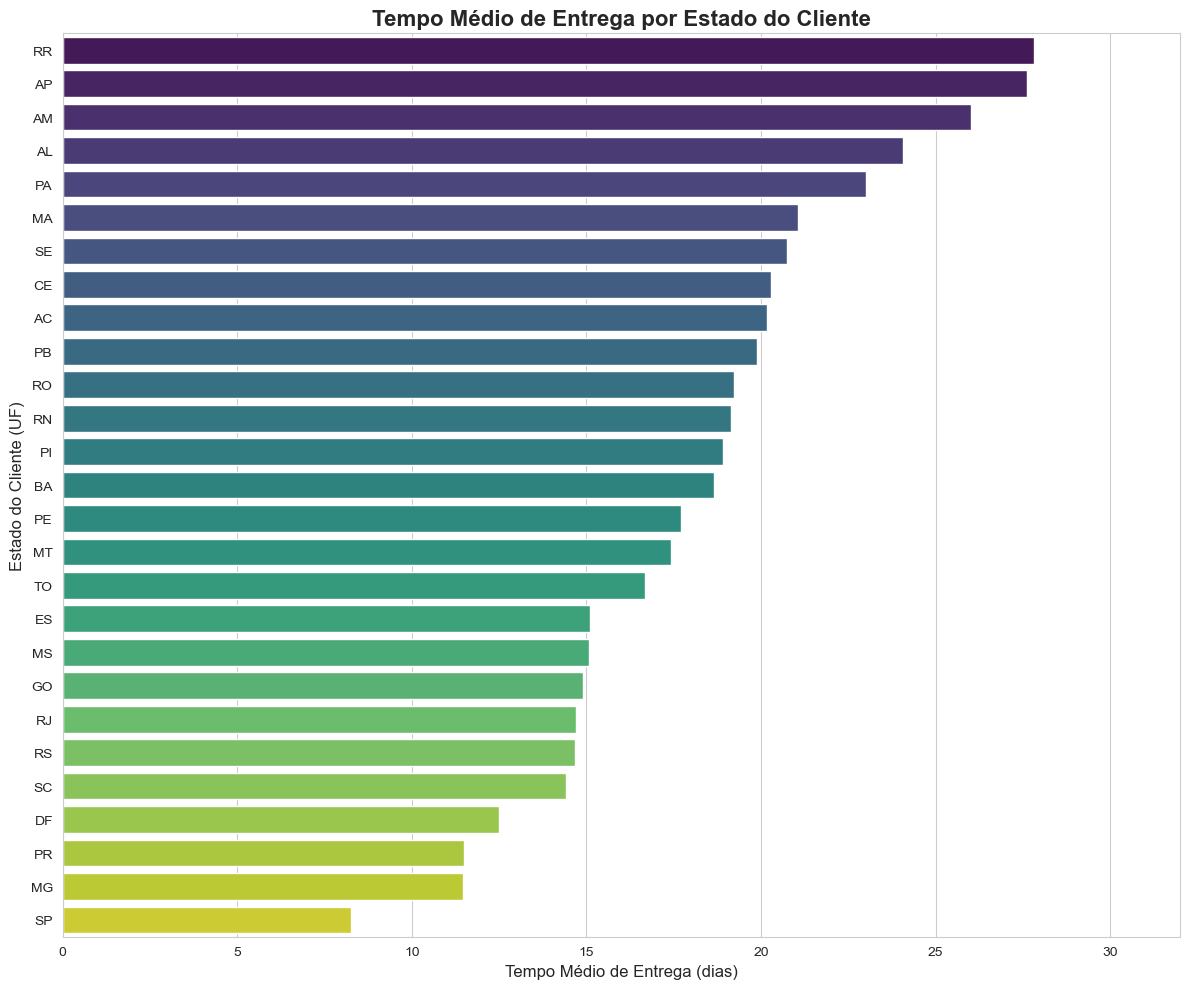

In [ ]:
#ANÁLISE E VISUALIZAÇÃO POR ESTADO ---

#Agregação dos Dados
# Calcular a média e a contagem de entregas por estado
media_por_estado = df_analise.groupby('customer_state')['tempo_entrega_dias'].agg(['mean', 'count']).reset_index()

# Ordenar os estados pelo tempo médio de entrega (do maior para o menor)
media_por_estado = media_por_estado.sort_values('mean', ascending=False)

print("\n--- Análise dos Resultados ---")
print("\nTempo Médio de Entrega e N. de Pedidos por Estado:")
print(media_por_estado)

# Configurações do gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(12, 10))

barplot = sns.barplot(
    x='mean',
    y='customer_state',
    data=media_por_estado,
    palette='viridis',
    hue='customer_state',
    dodge=False,
    legend=False
)

# Títulos e rótulos
plt.title('Tempo Médio de Entrega por Estado do Cliente', fontsize=16, weight='bold')
plt.xlabel('Tempo Médio de Entrega (dias)', fontsize=12)
plt.ylabel('Estado do Cliente (UF)', fontsize=12)
plt.xlim(0, media_por_estado['mean'].max() * 1.15) # Ajusta o limite do eixo X

# Exibir o gráfico
plt.tight_layout()
plt.show()

A conclusão mais imediata é a enorme disparidade no tempo de entrega entre as regiões do Brasil.

    • Os Mais Lentos: Estados da região Norte, como Roraima (RR), Amapá (AP) e Amazonas (AM), apresentam os piores desempenhos, com tempos médios que podem superar os 25 dias. O Nordeste também enfrenta prazos mais longos, com estados como Maranhão (MA) e Piauí (PI) no topo da lista.

    • Os Mais Rápidos: São Paulo (SP) tem o tempo de entrega mais rápido, frequentemente com uma média inferior a 8 dias. Outros estados do Sudeste e Sul, como Paraná (PR), Minas Gerais (MG) e Santa Catarina (SC), também apresentam uma performance logística muito superior.

A possível causa: Concentração de Vendedores e Malha Logística

Essa diferença não é um acaso. Ela reflete a realidade econômica e geográfica do Brasil e, especificamente, do modelo de marketplace da Olist:

    • Proximidade do Hub: A grande maioria dos vendedores (sellers) da Olist está concentrada no Sul e Sudeste. Quando um cliente de São Paulo compra, o produto viaja uma distância curta. Quando um cliente de Roraima compra o mesmo produto, ele precisa cruzar o país.
    
    • Infraestrutura: A malha logística (estradas, aeroportos, centros de distribuição) é muito mais densa e eficiente no Sudeste. O transporte para estados mais remotos enfrenta desafios como estradas piores, menor frequência de voos de carga e a necessidade de transporte fluvial na Amazônia, o que aumenta drasticamente o tempo e a complexidade.

## Machine Learning

Em machine learning, avaliar o desempenho de um modelo é crucial para entender se ele está fazendo um bom trabalho. As métricas servem exatamente para isso, e a escolha da métrica certa depende do tipo de problema que você está resolvendo: No nosso estudo aqui temos um problema de classificação.

In [ ]:
df_final.head()

,order_id,payment_value,price,product_weight_g,freight_value,product_photos_qty,delivery_time,delivery_delay,purchase_hour,purchase_day,purchase_month,purchase_dayofweek,satisfaction
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,58.90,650.0,13.29,4.0,7.0,-9.0,8,13,9,Wednesday,1
1,00018f77f2f0320c557190d7a144bdd3,259.83,239.90,30000.0,19.93,2.0,16.0,-3.0,10,26,4,Wednesday,1
2,000229ec398224ef6ca0657da4fc703e,216.87,199.00,3050.0,17.87,2.0,7.0,-14.0,14,14,1,Sunday,1
3,00024acbcdf0a6daa1e931b038114c75,25.78,12.99,200.0,12.79,1.0,6.0,-6.0,10,8,8,Wednesday,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,199.90,3750.0,18.14,1.0,25.0,-16.0,13,4,2,Saturday,1


In [ ]:
df_final.drop(['order_id'], axis=1, inplace=True)

In [ ]:
# Codificar variáveis categóricas
label_encoder = LabelEncoder()
df_final['purchase_dayofweek'] = label_encoder.fit_transform(df_final['purchase_dayofweek'])

In [ ]:
# 1. Lidar com valores ausentes (missing)
# Remove quaisquer linhas que ainda contenham valores nulos
df_processed = df_final.dropna()

# 2. Separar features (variáveis independentes) e target (variável alvo)
X = df_processed.drop(['satisfaction'], axis=1)
y = df_processed['satisfaction']

# 3. Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% dos dados para teste
    random_state=42,     # Garante que a divisão seja sempre a mesma
    stratify=y           # Mantém a proporção da variável 'satisfaction' em ambos os conjuntos
)

# 4. Isso coloca todas as features na mesma escala, o que ajuda muitos modelos a performar melhor.
numeric_features = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])

# transformar os dados de treino e de teste
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

Treinar um modelo de Regressão Logística

In [ ]:
# Treinar um modelo de Regressão Logística
model = LogisticRegression()
model.fit(X_train, y_train)
# E avalie no conjunto de teste original (X_test, y_test)
predictions = model.predict(X_test)

In [ ]:
#Calcular a acurácia
accuracy = accuracy_score(y_test, predictions)
print(f'Acurácia do modelo: {accuracy:.4f}\n')

#Gerar o relatório de classificação detalhado
report = classification_report(y_test, predictions)
print('Relatório de Classificação da Regressão Logística:\n')
print(report)

Acurácia do modelo: 0.8161

Relatório de Classificação da Regressão Logística:

              precision    recall  f1-score   support

           0       0.79      0.17      0.28      3976
           1       0.82      0.99      0.89     14925

    accuracy                           0.82     18901
   macro avg       0.80      0.58      0.59     18901
weighted avg       0.81      0.82      0.77     18901



Treinar um modelo de Random Forest

In [ ]:
# Treinar um modelo de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Avaliar o modelo de Random Forest
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Acurácia do Random Forest:", rf_accuracy)
print("Relatório de Classificação do Random Forest:")
print(classification_report(y_test, rf_predictions))

Acurácia do Random Forest: 0.8229723295063753
Relatório de Classificação do Random Forest:
              precision    recall  f1-score   support

           0       0.75      0.24      0.36      3976
           1       0.83      0.98      0.90     14925

    accuracy                           0.82     18901
   macro avg       0.79      0.61      0.63     18901
weighted avg       0.81      0.82      0.78     18901



O modelo atual é **excelente para identificar satisfeitos**, mas **ruim para detectar insatisfeitos**. Para um programa de retenção de clientes e melhoria de experiência, será necessário melhorar a detecção da classe 0, mesmo que isso sacrifique um pouco a performance geral. Tratar o desbalanceamento.

**Possíveis soluções**:
1. Mais dados da classe 0 - Insatisfeito
2. Feature engineering específico
3. Modelos especializados na classe minoritária


In [ ]:
# Treinar um modelo de Support Vector Machine (SVM)
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)

# Avaliar o modelo SVM
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("\nAcurácia do SVM:", svm_accuracy)
print("Relatório de Classificação do SVM:")
print(classification_report(y_test, svm_predictions))


Acurácia do SVM: 0.819639172530554
Relatório de Classificação do SVM:
              precision    recall  f1-score   support

           0       0.83      0.18      0.29      3976
           1       0.82      0.99      0.90     14925

    accuracy                           0.82     18901
   macro avg       0.82      0.58      0.60     18901
weighted avg       0.82      0.82      0.77     18901



O modelo atual é muito ruim para negócio. Apesar da acurácia de aproximadamente 82%, ele falha em detectar 82% dos clientes insatisfeitos, o que representa um grande enorme

Classe 0 (Insatisfeitos - CRÍTICO):

Precision (83%): Quando prevê insatisfeito, raramente erra

Recall (18%): FALHA - Apenas 18% dos verdadeiros insatisfeitos detectados

F1-Score (29%): Performance ruim

Classe 1 (Satisfeitos):

Precision (82%): Bom desempenho em prever satisfeitos

Recall (99%): Praticamente perfeito - detecta quase todos satisfeitos

F1-Score (90%): Excelente performance para classe majoritária

# Curva ROC e Área Sob a Curva (AUC) para o modelo Random Forest

In [ ]:
from sklearn.metrics import roc_auc_score

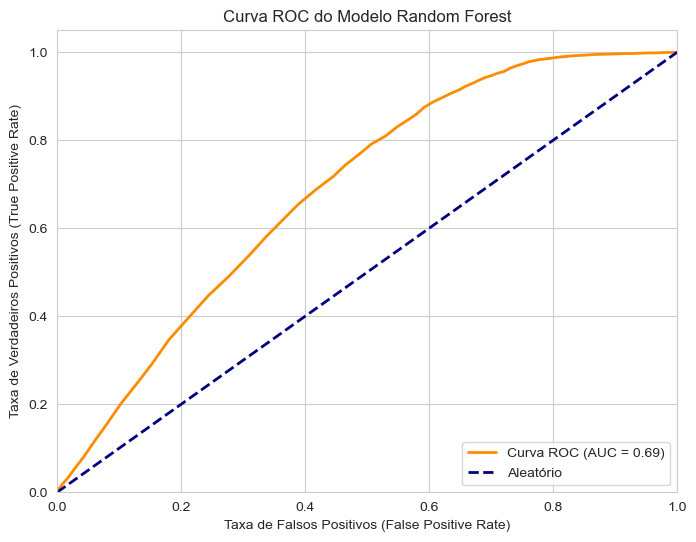

O valor de AUC é: 0.6870


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obter as probabilidades de previsão para a classe positiva (y=1)
# O AUC e a curva ROC precisam das probabilidades, não das previsões diretas (0 ou 1)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Calcular a Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular a Área Sob a Curva (AUC)
roc_auc = auc(fpr, tpr)

# Plotar a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório') # Linha de base aleatória
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC do Modelo Random Forest')
plt.legend(loc="lower right")
plt.show()

print(f"O valor de AUC é: {roc_auc:.4f}")

O código na célula anterior gera a Curva ROC (Receiver Operating Characteristic) e calcula a Área Sob a Curva (AUC) para avaliar o desempenho do modelo Random Forest que você treinou. Aqui está uma explicação detalhada:

Importação de Bibliotecas:

from sklearn.metrics import roc_curve, auc: Importa as funções necessárias para calcular a curva ROC (roc_curve) e a área sob ela (auc) do módulo sklearn.metrics.

import matplotlib.pyplot as plt: Importa a biblioteca matplotlib para criar o gráfico.

Obter Probabilidades de Previsão:

y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]:

Esta linha é crucial. Os modelos de classificação no scikit-learn geralmente têm um método predict_proba() que retorna as probabilidades de cada classe para cada amostra de entrada. [:, 1] seleciona apenas as probabilidades da classe positiva (neste caso, a classe 1, que representa "satisfeito").

A curva ROC é construída usando essas probabilidades, não as previsões binárias (0 ou 1).

Calcular a Curva ROC:

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba): A função roc_curve() calcula os valores da Taxa de Falsos Positivos (FPR) e da Taxa de Verdadeiros Positivos (TPR) para vários limites de classificação (thresholds).
FPR (False Positive Rate): A proporção de negativos reais que são incorretamente identificados como positivos.
TPR (True Positive Rate): A proporção de positivos reais que são corretamente identificados como positivos (também conhecido como Recall ou Sensibilidade).

Calcular a Área Sob a Curva (AUC):

roc_auc = auc(fpr, tpr): A função auc() calcula a área sob a curva ROC usando os valores de FPR e TPR obtidos anteriormente. O valor da AUC varia de 0 a 1.

Uma AUC de 0.5 indica um modelo que não é melhor do que a classificação aleatória, enquanto uma AUC de 1.0 indica um modelo perfeito.

Plotar a Curva ROC:

plt.figure(figsize=(8, 6)): Cria uma nova figura para o gráfico com um tamanho especificado.

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})'): Plota a curva ROC, com o FPR no eixo x e o TPR no eixo y. A legenda inclui o valor da AUC formatado.

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório'):

Adiciona uma linha diagonal pontilhada que representa um classificador aleatório (AUC de 0.5). Serve como linha de base para comparação.

plt.xlim([0.0, 1.0]) e plt.ylim([0.0, 1.05]): Define os limites dos eixos x e y.

plt.xlabel(...), plt.ylabel(...), plt.title(...): Define os rótulos dos eixos e o título do gráfico.

plt.legend(loc="lower right"): Exibe a legenda do gráfico.

plt.show(): Mostra o gráfico.

Imprimir o Valor da AUC:

print(f"O valor de AUC é: {roc_auc:.4f}"): Imprime o valor calculado da AUC, formatado para 4 casas decimais.


Em resumo, este código visualiza a capacidade do seu modelo Random Forest de distinguir entre as classes positiva (satisfeito) e negativa (insatisfeito) em diferentes limites de classificação, e o valor da AUC fornece uma métrica única para quantificar essa capacidade discriminatória geral.

Interpretação de um AUC de 0.6870
Um valor de AUC de 0.6870 pode ser interpretado da seguinte forma:

Significado Direto: Existe uma probabilidade de 68.70% de que o modelo atribuirá uma pontuação de previsão mais alta a um exemplo positivo escolhido aleatoriamente do que a um exemplo negativo escolhido aleatoriamente. Em outras palavras, se você pegar um "sim" e um "não" aleatórios do seu conjunto de dados, há uma chance de 68.70% de que o modelo classifique o "sim" corretamente com uma probabilidade maior do que o "não".

Qualidade do Modelo:

Melhor que o Aleatório: O valor de 0.6870 está acima de 0.5, o que significa que o seu modelo tem uma capacidade de discriminação melhor do que um palpite aleatório. Ele aprendeu algo útil a partir dos dados.

Desempenho Razoável, mas não Excelente: Geralmente, um AUC entre 0.6 e 0.7 é considerado um desempenho fraco ou, na melhor das hipóteses, razoável. O modelo tem algum poder preditivo, mas comete um número considerável de erros ao distinguir as classes.

Tabela de Referência Geral
Embora a interpretação possa variar um pouco dependendo do domínio do problema (em medicina, um AUC de 0.8 pode ser considerado baixo, enquanto em marketing pode ser bom), uma regra geral comum é:

Valor do AUC	Interpretação Geral
0.90 - 1.00	Excelente
0.80 - 0.90	Muito Bom
0.70 - 0.80	Bom / Aceitável
0.60 - 0.70	Fraco / Razoável
0.50 - 0.60	Ruim (pouco melhor que o aleatório)
Abaixo de 0.50	Sem capacidade de discriminação

# **5. Resumo da Análise e Recomendações**

Nossa jornada analítica revelou padrões críticos que transformam dados em oportunidades de negócio tangíveis. Baseando-nos na distribuição das avaliações, na correlação entre tempo de entrega e satisfação, e nos padrões geográficos, apresentamos recomendações acionáveis para otimizar a operação da Olist.

Recomendações:

- Desenvolver operação logística dedicada para regiões com maior desafio;

- Estabelecer centros de distribuição regionais para reduzir tempo de trânsito;

- Treinamento específico para vendedores que atendem estas regiões;

- Sistema de alertas preditivos para identificar riscos de insatisfação antes da entrega;

- Implementar sistema de alertas proativos para pedidos com previsão de atraso;

- Estabelecer partnerships prioritárias com transportadoras que apresentam melhor performance por região;

- Criar programa de compensação automática para clientes com atrasos superiores a 5 dias úteis.


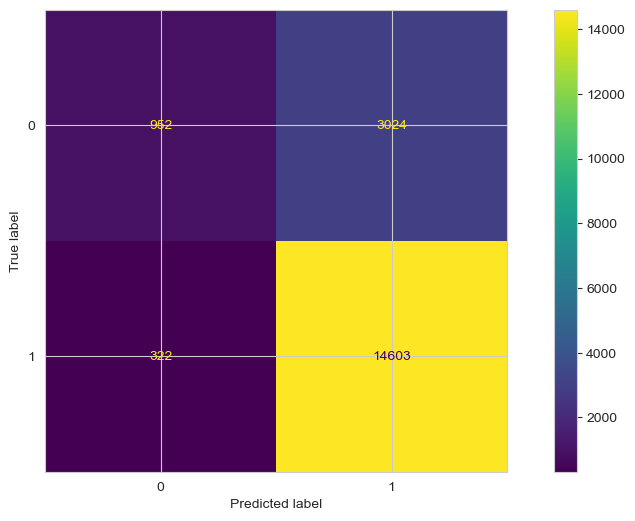

In [ ]:
#Matriz de Confusão - RandomForest
cm_display = ConfusionMatrixDisplay.from_estimator(rf_classifier, X_test, y_test,g)

In [ ]:
pred_clf = rf_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matriz = confusion_matrix(y_test, pred_clf)
cf_matriz

array([[  952,  3024],
       [  322, 14603]], dtype=int64)